# Model Interpretability and Independent validation using model with transfer learning over independent validation dataset

In this notebook we are exploring the results of the clinical transformer to identify the important features (functional groups, feature permutation importance) as well as the impact on survival (Kapplan-Meier curves on the predicted populations). 

In [48]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append('../../../codeocean/environment/clinical_transformer/')

In [49]:
from xai.models.explainer import TransformerSurvivalEvaluator
from xai.models.explainer import survival_attention_scores
from xai.models import load_transformer

In [50]:
import pandas as pd
from samecode.random import set_seed
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from samecode.survival.plot import KMPlot
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index as lfcindex
import seaborn as sns
from shap.plots import colors
from glob import glob
import os
colors = [colors.blue_rgb, colors.red_rgb]

In [51]:
n_feats = 29

100%|█████████████████████████████████████████████████████████████████████████████████| 298/298 [00:06<00:00, 48.06it/s]


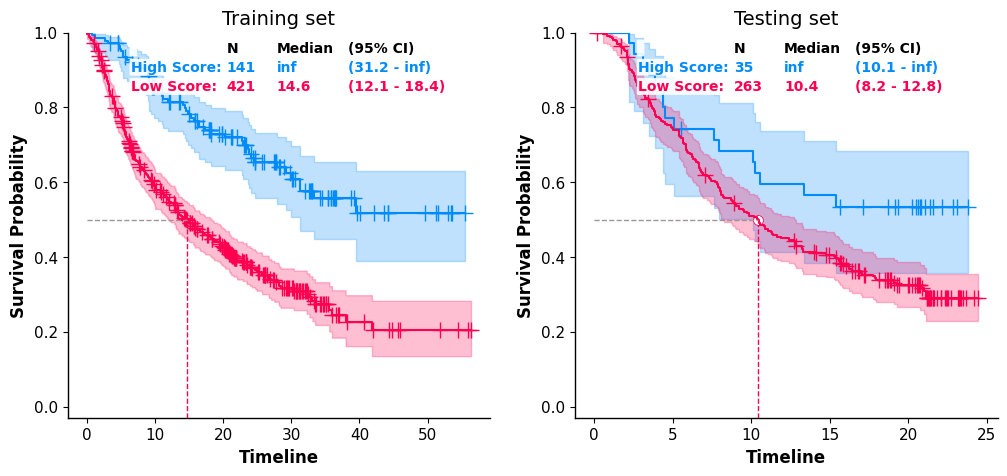

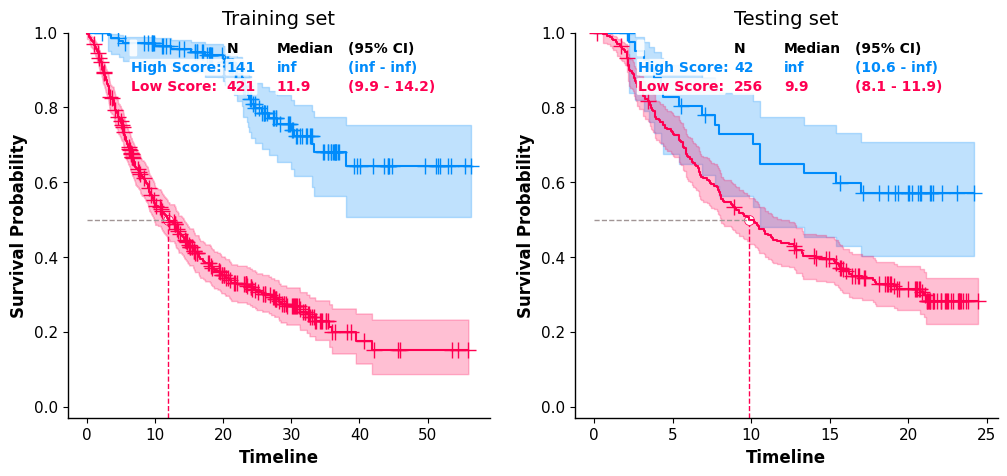

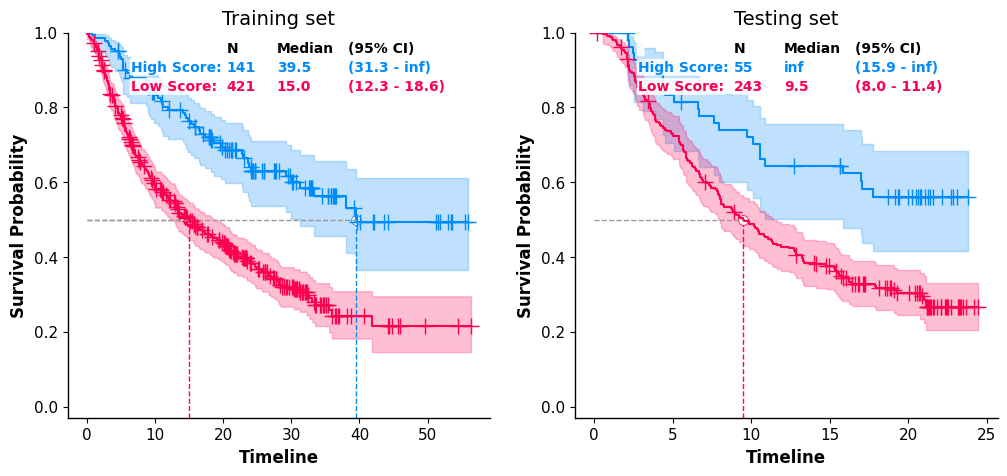

In [54]:
p0 = './results/TransferLearningSurvival_all/model.E002000.h5/'
p1 = './results/TransferLearningSurvival/model.E002000.h5/'
p2 = './results/Survival/'

cindex_res = []
for path in [p0, p1, p2]:
    
    train_data = pd.read_csv('./data/dataset-train.data.csv')
    train_data['sample_id'] = train_data.index
    test_data = pd.read_csv('./data/dataset-test.data.csv')

    test_data['sample_id'] = test_data.index
    features = train_data.columns[-n_feats:].tolist()

    sample_id = 'sample_id'
    all_epoch = 300
    if path == p0:
        all_epoch = 148
    res = pd.Series(glob(os.path.join(path, '*/history.csv')))

    pp = res.apply(lambda x:x.replace(path, ''))
    fd = pp.apply(lambda x:x.split('/')[0])
    eps = res.apply(lambda x:pd.read_csv(x).val_loss.idxmin())
    dfres = pd.concat([res,fd,eps], axis=1)
    best_model_paths =dfres.set_index(1)[2]

    
    train_beta  = []
    test_beta = []
    train_c = []
    test_c = []

    for run, best_epoch in best_model_paths.items():
        
        epoch = best_epoch
        trainer = load_transformer(path, run, epoch=epoch)
        transformed_data = trainer.data_converter.transform(train_data).reset_index(drop=True)

        set_seed(0)

        evaluator = TransformerSurvivalEvaluator(model=trainer)

        train_data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
            transformed_data, evaluator, iterations=1, sample_id=sample_id
        )

        train_cindex = lfcindex(train_data['time'], train_data['β'], train_data['event'])

        transformed_test_data = trainer.data_converter.transform(test_data).reset_index(drop=True)


        evaluator = TransformerSurvivalEvaluator(model=trainer)

        test_data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
            transformed_test_data, evaluator, iterations=10, sample_id=sample_id
        )

        test_cindex = lfcindex(test_data['time'], test_data['β'], test_data['event'])

        test_c.append(test_cindex)
        train_c.append(train_cindex)
        test_beta.append(test_data['β'])     
        train_beta.append(train_data['β'])

    df_cindex = pd.DataFrame([test_c, train_c]).T
    df_cindex.columns = ['test_cindex', 'train_cindex']
    
    cindex_dict = df_cindex.mean().to_dict()
    cindex_res.append(cindex_dict)
    
    train_βs = pd.concat(train_beta, axis=1)
    test_βs = pd.concat(test_beta, axis=1)


    test_βs.columns = ['β_%s' % i for i in range(len(test_βs.columns))]
    train_βs.columns = ['β_%s' % i for i in range(len(train_βs.columns))]


    test_data['β'] = test_βs.mean(axis=1)
    train_data['β'] = train_βs.mean(axis=1)
    
    median_cutoff = np.quantile(train_data.β, 0.75)


    test_data['population'] = (test_data.β >= median_cutoff).replace([False, True], ['Low Score', 'High Score'])
    train_data['population'] = (train_data.β >= median_cutoff).replace([False, True], ['Low Score', 'High Score'])

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5))
    KMPlot(train_data, time='time', event='event', label=['population']).plot(ax=axs[0], 
                                                                              colors = colors, 
                                                                              title='Training set',
                                                                              ci_show=True,ci_alpha=0.10,

                                                                             )
    KMPlot(test_data, time='time', event='event', label=['population']).plot(ax=axs[1],
                                                                             colors = colors, ci_show=True,
                                                                             ci_alpha=0.10,
                                                                             title='Testing set')
    
    test_data = test_data.join(test_βs)
    train_data = train_data.join(train_βs)
    
    test_data.to_csv(os.path.join(path, 'test_data.csv'))
    train_data.to_csv(os.path.join(path, 'train_data.csv'))
    fig.savefig(os.path.join(path, 'train_test_km.svg'), bbox_inches='tight')
    df_cindex.to_csv(os.path.join(path, 'train_test_cindex.csv'))

In [55]:
cindex_res

[{'test_cindex': 0.5755459951223523, 'train_cindex': 0.651913533936529},
 {'test_cindex': 0.5680130435974023, 'train_cindex': 0.7272152070358754},
 {'test_cindex': 0.573534650480914, 'train_cindex': 0.6494120199217231}]